# Assignment 1 - Bandit

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Bernoulli class

In [2]:

class Bernoulli:
    def __init__(self, probs, lr=1, epsilon=0.0, UCB_param=None):
        self.arm_prob = np.array(probs)
        self.arm_step = np.zeros(len(probs))
        self.expeted = np.zeros(len(probs))
        self.learning_rate = lr
        self.epsilon = epsilon
        self.total_reward_avg = 0
        self.UCB_param = UCB_param
        self.action_count = np.zeros(len(probs))

    def sample(self, index, qty=1):
        prob = self.arm_prob[index]
        samples = np.random.binomial(1, prob, qty)
        return samples

    def greedy_arm(self):
        higher_value = self.expeted.max()
        indexes = np.where(self.expeted == higher_value)[0]
        if len(indexes) > 1:
            chosen = np.random.choice(indexes)
        else:
            chosen = indexes[0]
        return chosen

    def ucb_sample(self, learning_rate=None):
        # formula for UCB equation
        UCB_estimation = self.expeted + self.UCB_param * np.sqrt(
            np.log(np.sum(self.arm_step) + 1) / (self.arm_step + 1e-5))
        q_best = np.max(UCB_estimation)
        arm_index = np.random.choice(np.where(UCB_estimation == q_best)[0])

        sample = self.sample(arm_index)
        self.update(sample, arm_index=arm_index, lr=learning_rate)
        return sample, arm_index

    def greed_sample(self, epsilon=None, lr=None):
        if epsilon is None:
            epsilon = self.epsilon
        if lr is None:
            lr = self.learning_rate

        if np.random.random() < epsilon:
            arm_index = np.random.choice(range(len(self.arm_prob)))
        else:
            arm_index = self.greedy_arm()

        sample = self.sample(arm_index)
        self.update(sample, arm_index, lr)

        return sample, arm_index

    def thompson_sampling_algorithm_sample(self, lr=None):
        if lr is None:
            lr = self.learning_rate


        samples = np.random.beta(self.action_count + 1, self.arm_step - self.action_count + 1)
        arm_index = np.argmax(samples)

        sample = self.sample(arm_index)
        self.update(sample, arm_index, lr)

        return sample, arm_index


    def update(self, reward, arm_index, lr=None):
        if lr is None:
            lr = self.learning_rate
        previous = self.expeted[arm_index]
        self.arm_step[arm_index] = self.arm_step[arm_index] + 1
        if reward > 0:
            self.action_count[arm_index] = self.action_count[arm_index] + 1
        self.expeted[arm_index] = updateAvg(previous, reward, lr, self.arm_step[arm_index])
        self.total_reward_avg = updateAvg(self.total_reward_avg, reward, lr, np.sum(self.arm_step))
        return


def update(values, lr):
    avg_ot = values[:, 0].reshape(-1, 1)

    for index, reward in enumerate(values[:, 1:].T):
        old_avg = avg_ot[:, index]
        new_avg = updateAvg(old_avg, reward, lr, index + 2)
        avg_ot = np.hstack([avg_ot, new_avg.reshape(-1, 1)])
    return avg_ot


def updateAvg(prev, reward, lr, step_size=1):
    if lr == 1:
        new = prev + lr * (reward - prev) / step_size
    else:
        new = prev + lr * (reward - prev)
    return new


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Question 1

In [3]:
delta = -.1

alphas = [1, .1, .01]

probs = [.5, .5 + delta, .5 + 2 * delta]

colors = ['red', 'green', 'blue', 'purple']

bandit = Bernoulli(probs)

In [4]:
sample_size = (1,50)

arr = []
for index,arm in enumerate(bandit.arm_prob):
    arr.append(bandit.sample(index,sample_size))

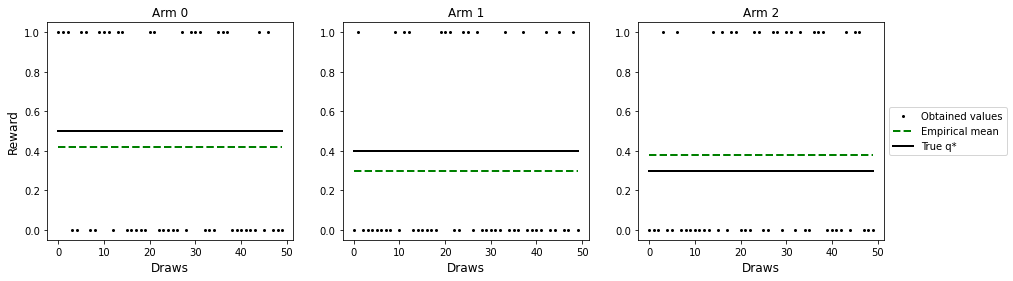

In [5]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for index,arm in enumerate(arr):
    plt.subplot(1,3,index + 1)
    arm = arm[0]
    plt.plot(arm,'o',c='black', markersize=2, label='Obtained values')
    plt.plot([np.mean(arm)]*len(arm),c='green', linestyle='dashed',linewidth=2, label='Empirical mean')
    plt.plot([bandit.arm_prob[index]]*len(arm),c='black', linewidth=2, label='True q*')
    plt.xlabel('Draws',fontsize=12)
    if index == 0:
        plt.ylabel('Reward',fontsize=12)
    plt.title('Arm {}'.format(index))
    if index == 2:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Question 2

In [6]:
sample_size = (1,100)

arr = []
for index,arm in enumerate(bandit.arm_prob):
    arr.append(bandit.sample(index,sample_size))


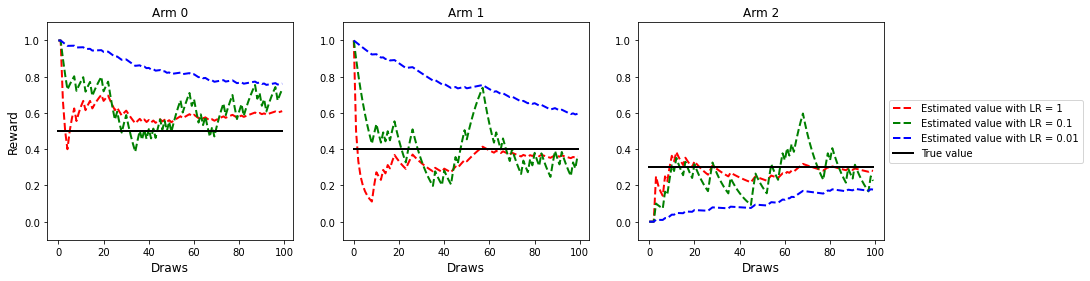

In [7]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for index, arm in enumerate(arr):
    plt.subplot(1,3,index +1)
    for c_index, alpha in enumerate(alphas):
        matrix = update(arm, alpha)
        matrix_m = np.mean(matrix, axis=0)
        plt.plot(matrix_m, c=colors[c_index], linestyle='dashed', linewidth=2, label='Estimated value with LR = {}'.format(alpha))
    plt.plot([bandit.arm_prob[index]] * arm.shape[1], c='black', linewidth=2, label='True value')
    plt.ylim([-.1, 1.1])
    plt.xlabel('Draws', fontsize=12)
    if index == 0:
        plt.ylabel('Reward', fontsize=12)
    plt.title('Arm {}'.format(index))
    if index == 2:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
   

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Question 3

In [8]:
sample_size = (100,100)

arr = []
for index, arm in enumerate(bandit.arm_prob):
    arr.append(bandit.sample(index, sample_size))


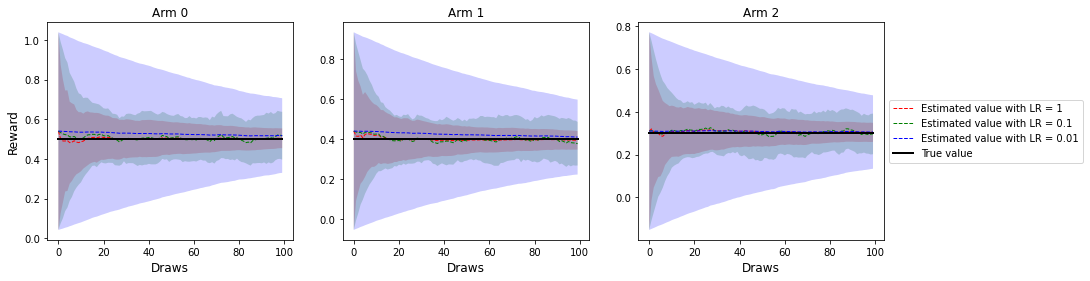

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
for index, arm in enumerate(arr):
    plt.subplot(1,3,index +1)
    for c_index, alpha in enumerate(alphas):
        matrix = update(arm, alpha)
        matrix_m = np.mean(matrix, axis=0)
        arr_std = np.std(matrix, axis=0)
        plt.plot(matrix_m, c=colors[c_index], linestyle='dashed', linewidth=1,
                 label='Estimated value with LR = {}'.format(alpha))
        lower_bound = matrix_m - arr_std
        upper_bound = matrix_m + arr_std
        plt.fill_between(list(range(arm.shape[1])), lower_bound, upper_bound, facecolor=colors[c_index], alpha=0.2,
                         linewidth=4,
                         linestyle='dashdot', antialiased=True)
    plt.plot([bandit.arm_prob[index]] * arm.shape[1], c='black', linewidth=2, label='True value')
    plt.xlabel('Draws', fontsize=12)
    if index == 0:
        plt.ylabel('Reward', fontsize=12)
    plt.title('Arm {}'.format(index))
    if index == 2:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Comments
The lower learning rate/alpha decrease the speed in wich the model will learn, therefore if the number of timesteps is predicted to be a very high value it might be worth to lower it, however, for low values like this experiments, averaging (alpha = 1) seems to be better.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Question 4

In [10]:
#defining needed values

runs = 100
time_steps = 1000

In [11]:
def run(runs, time_steps, epsilon=1/8, alpha=1, UCB_param=2, bandit_t='greedy',non_stationay=False):
    #  arrays that will store the values over the runs
    expected_reward = []
    reward_obtained = []
    arm_chosen = []
    standard_error = []
    instant_regret = []
    cumulated_regret = []
    optimal_chosen = []

    for run_number in range(runs):

        #  values aquired on this run
        bandit = Bernoulli(probs, epsilon=epsilon, lr=alpha, UCB_param=UCB_param)
        action = {'greedy':bandit.greed_sample,'ucb':bandit.ucb_sample,'thompson':bandit.thompson_sampling_algorithm_sample}[bandit_t]
        expected_ot = []
        reward_ot = []
        arm_pulled = []
        std_error = []
        regret = []
        cum_regret = []

        for step in range(time_steps):
            if non_stationay and (step == 500):
                bandit.arm_prob = [.5,.6,.7]
            reward, arm = action()
            reward_ot.append(reward)
            expected_ot.append(bandit.expeted)
            std_error.append(np.std(np.array(expected_ot).T))
            arm_pulled.append(arm)
            regret.append(np.max(bandit.arm_prob) - bandit.arm_prob[arm])
            cum_regret.append(np.sum(regret))

        optimal = np.argmax([arm_pulled.count(x) for x in np.unique(arm_pulled)]) == np.argmax(bandit.arm_prob)
        reward_ot = [x[0] for x in reward_ot]

        #  storing arrays
        expected_reward.append(expected_ot)
        reward_obtained.append(reward_ot)
        arm_chosen.append(arm_pulled)
        standard_error.append(std_error)
        instant_regret.append(regret)
        cumulated_regret.append(cum_regret)
        optimal_chosen.append(optimal)
        
    # getting the average over the runs
    reward_obtained = np.mean(reward_obtained, axis=0)
    standard_error = np.std(reward_obtained, axis=0)
    optimal_chosen = sum(optimal_chosen)
    instant_regret = np.mean(instant_regret, axis=0)
    cumulated_regret = np.mean(cumulated_regret, axis=0)
    
    return reward_obtained, optimal_chosen, instant_regret, cumulated_regret

In [49]:
def plots(X,a,b,c,d):
    # a)
    for alpha,epsilon,line in a:
        label = ''
        if epsilon is not None:
            label += 'Epsilon: {}'.format(epsilon)
        if alpha == 1:
            label += '\n With averaging method'
        elif alpha is not None:
            label += '\n Alpha: {}'.format(alpha)
            
        plt.plot(X, line,label=label)
        arr_std = np.std(line)
        lower_bound = line - arr_std
        upper_bound = line + arr_std
        plt.fill_between(X, lower_bound, upper_bound, alpha=0.2,linewidth=4,
                         linestyle='dashdot', antialiased=False)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title("Reward received over time")
        plt.xlabel("Time steps / draws")
    plt.show()
    # b)
    for alpha,epsilon,value in b:
        if (epsilon is not None) and (alpha is not None):
            print('With epsilon of {} and alpha of {} the percentage of times where the optimal arm was the most chosen one was {}%'.format(epsilon,alpha, value))
        elif epsilon is not None:
            print('With epsilon of {} the percentage of times where the optimal arm was the most chosen one was {}%'.format(epsilon, value))
        elif alpha == 1:
            print('When using averaging method the percentage of times where the optimal arm was the most chosen one was {}%'.format(value))
        else:
            print('With alpha of {} the percentage of times where the optimal arm was the most chosen one was {}%'.format(alpha, value))

    # c)
    for alpha,epsilon,line in c:
        label = ''
        if epsilon is not None:
            label += 'Epsilon: {}'.format(epsilon)
        if alpha == 1:
            label += '\n With averaging method'
        elif alpha is not None:
            label += '\n Alpha: {}'.format(alpha)
        plt.plot(X, line,label=label)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title("Instantaneous regret")
        plt.xlabel("Time steps / draws")
    plt.show()
    # d)
    for alpha,epsilon,line in d:
        label = ''
        if epsilon is not None:
            label += 'Epsilon: {}'.format(epsilon)
        if alpha == 1:
            label += '\n With averaging method: '
        elif alpha is not None:
            label += '\n Alpha: {}'.format(alpha)
        plt.plot(X, line,label=label)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title("Total regret")
        plt.xlabel("Time steps / draws")
    plt.show()
    

In [24]:
a = []
b = []
c = []
d = []

for epsilon in [0, 1/8, 1/4, 1/2, 1]:
    a_, b_, c_, d_ = run(runs, time_steps, epsilon)
    a.append((None,epsilon,a_))
    b.append((None,epsilon,b_))
    c.append((None,epsilon,c_))
    d.append((None,epsilon,d_))

In [14]:
X = list(range(time_steps))  # generating the X axis

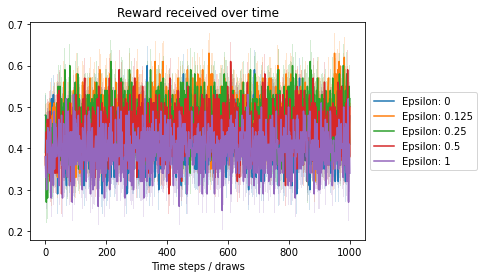

With epsilon of 0 the percentage of times where the optimal arm was the most chosen one was 85%
With epsilon of 0.125 the percentage of times where the optimal arm was the most chosen one was 88%
With epsilon of 0.25 the percentage of times where the optimal arm was the most chosen one was 90%
With epsilon of 0.5 the percentage of times where the optimal arm was the most chosen one was 99%
With epsilon of 1 the percentage of times where the optimal arm was the most chosen one was 32%


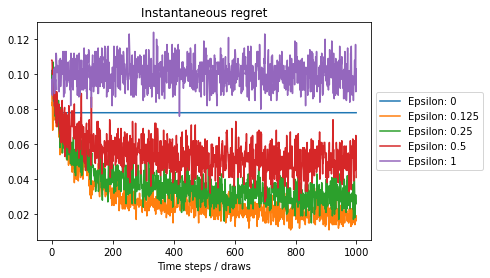

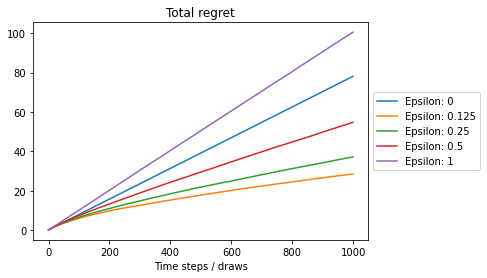

In [15]:
# plotting the graphs
plots(X,a,b,c,d)

### Comments
Lower values of epsilon leads to lower regret, however a value of 0 will result in a worse performance, since the first sample to get an 1 will probably end up being picked all the way, being almost as bad as picking randomly like epsilon 1. Therefore a low value will ensure a good exploitation while exploring from time to time


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Question 5

In [25]:
# generating values for plots

a = []
b = []
c = []
d = []

for epsilon in [1/4,1/8]:
    for alpha in [.1, .01, .001]:
        a_, b_, c_, d_ = run(runs, time_steps, epsilon, alpha)
        a.append((alpha,epsilon,a_))
        b.append((alpha,epsilon,b_))
        c.append((alpha,epsilon,c_))
        d.append((alpha,epsilon,d_))

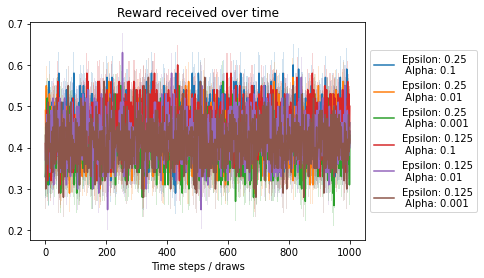

With epsilon of 0.25 and alpha of 0.1 the percentage of times where the optimal arm was the most chosen one was 98%
With epsilon of 0.25 and alpha of 0.01 the percentage of times where the optimal arm was the most chosen one was 48%
With epsilon of 0.25 and alpha of 0.001 the percentage of times where the optimal arm was the most chosen one was 42%
With epsilon of 0.125 and alpha of 0.1 the percentage of times where the optimal arm was the most chosen one was 93%
With epsilon of 0.125 and alpha of 0.01 the percentage of times where the optimal arm was the most chosen one was 51%
With epsilon of 0.125 and alpha of 0.001 the percentage of times where the optimal arm was the most chosen one was 40%


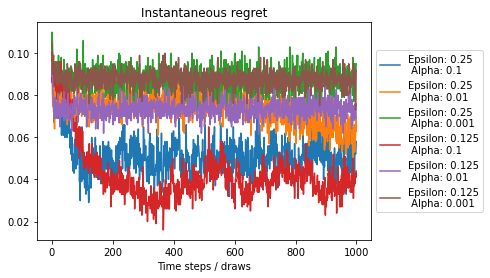

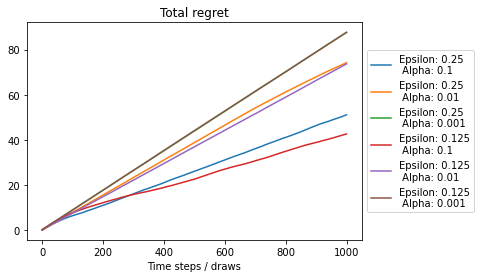

In [26]:
# plotting the graphs
plots(X,a,b,c,d)


### Comments
Good values sometimes depend on a combination of parameters. And both should be optimized in junction since they can affect the way each other interact with the learning of the model.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Question 6

In [28]:
a = []
b = []
c = []
d = []

for alpha in [0.1, 0.01, 0.001]:
    a_, b_, c_, d_ = run(runs, time_steps, alpha, UCB_param=1, bandit_t='ucb')
    a.append((alpha,None,a_))
    b.append((alpha,None,b_))
    c.append((alpha,None,c_))
    d.append((alpha,None,d_))

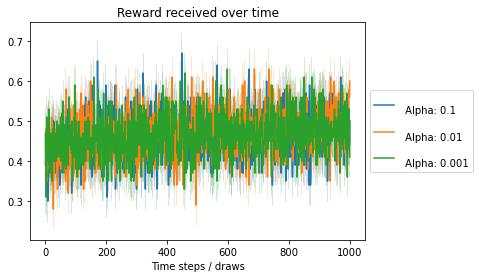

With alpha of 0.1 the percentage of times where the optimal arm was the most chosen one was 99%
With alpha of 0.01 the percentage of times where the optimal arm was the most chosen one was 100%
With alpha of 0.001 the percentage of times where the optimal arm was the most chosen one was 100%


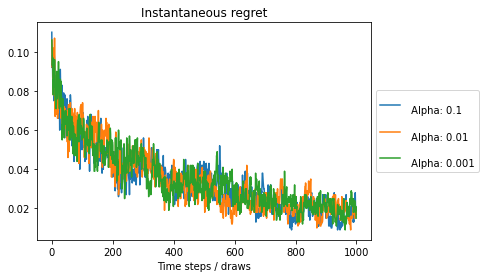

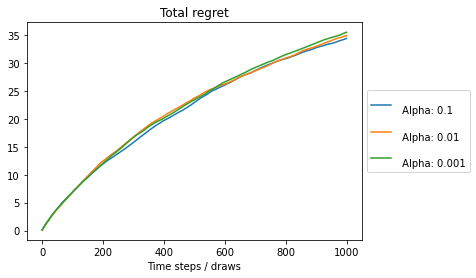

In [29]:
# plotting the graphs
plots(X,a,b,c,d)

### Comments
For ucb, the total regret was lower then a few configurations of the e-greedy, however with a good selection of alpha and epsilon it was possible to match the performance.

### Question 7

In [50]:
a = []
b = []
c = []
d = []

for alpha in [1, 0.1, 0.01, 0.001]:
    a_, b_, c_, d_ = run(runs, time_steps, alpha=alpha, bandit_t='thompson')
    a.append((alpha,None,a_))
    b.append((alpha,None,b_))
    c.append((alpha,None,c_))
    d.append((alpha,None,d_))

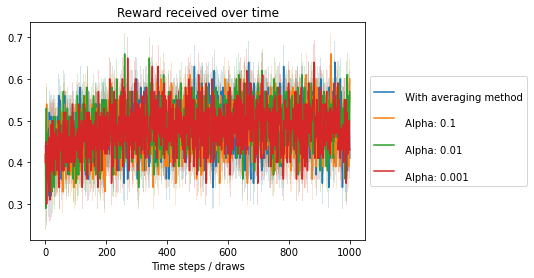

When using averaging method the percentage of times where the optimal arm was the most chosen one was 97%
With alpha of 0.1 the percentage of times where the optimal arm was the most chosen one was 93%
With alpha of 0.01 the percentage of times where the optimal arm was the most chosen one was 98%
With alpha of 0.001 the percentage of times where the optimal arm was the most chosen one was 100%


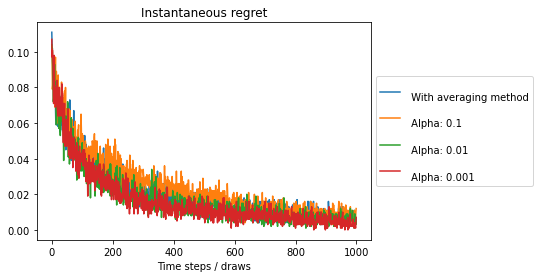

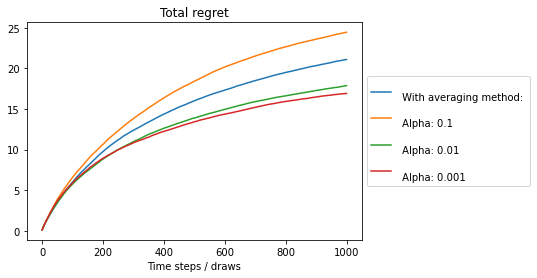

In [51]:
# plotting the graphs
plots(X,a,b,c,d)

### Comments
The Thompson sampling method managed to show an even better performance with any value for alpha showing extremly low values of cumulated regret, while also locking on the good arm quickly and frequently.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Question 8

#### e-greedy:
epsilon = 1/8
alpha = 0.1 

#### ucb:
alpha = 0.1 

#### Thompson:
alpha = 0.1 


In [45]:
a_greedy, b_greedy, c_greedy, d_greedy = run(runs, time_steps, epsilon=1/8, alpha=.1)
a_ucb, b_ucb, c_ucb, d_ucb = run(runs, time_steps,alpha=.1, bandit_t='ucb')
a_Thompson, b_Thompson, c_Thompson, d_Thompson = run(runs, time_steps,alpha=.1, bandit_t='thompson')


In [46]:
a = [a_greedy,a_ucb,a_Thompson]
b = [b_greedy,b_ucb,b_Thompson]
c = [c_greedy,c_ucb,c_Thompson]
d = [d_greedy,d_ucb,d_Thompson]

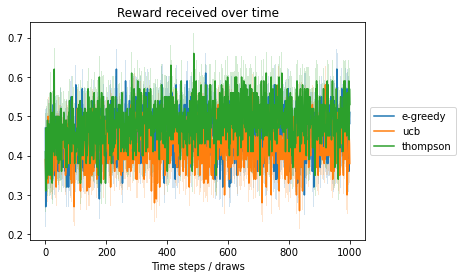

The e-greedy model chose the optimal arm more 93% of the times
The ucb model chose the optimal arm more 83% of the times
The thompson model chose the optimal arm more 99% of the times


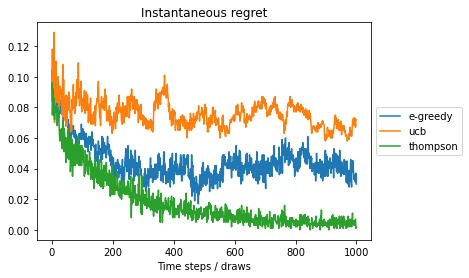

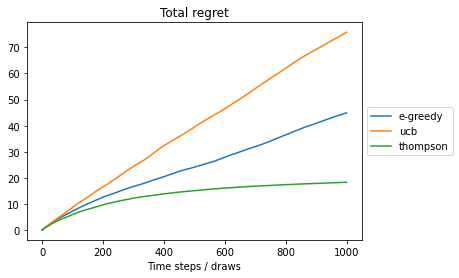

In [47]:
# a)
labels = ['e-greedy','ucb','thompson']

counter = 0
for value in a:
    line = value
    plt.plot(X, line,label=labels[counter])
    counter +=1
    arr_std = np.std(line)
    lower_bound = line - arr_std
    upper_bound = line + arr_std
    plt.fill_between(X, lower_bound, upper_bound, alpha=0.2,linewidth=4,
                     linestyle='dashdot', antialiased=False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Reward received over time")
    plt.xlabel("Time steps / draws")
plt.show()

counter = 0
# b)
for line in b:
    print('The {} model chose the optimal arm more {}% of the times'.format(labels[counter], line))
    counter +=1
    
counter = 0
# c)
for line in c:
    plt.plot(X, line,label=labels[counter])
    counter +=1
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Instantaneous regret")
    plt.xlabel("Time steps / draws")
plt.show()

counter = 0
# d)
for line in d:
    plt.plot(X, line,label=labels[counter])
    counter +=1
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Total regret")
    plt.xlabel("Time steps / draws")
plt.show()
    

### Comments
The UCB outperformer  the greedy by a slight margin as expected, however the big winner here is clearly the thompson, with an total regret considerably lower then the other 2 while also keeping a higher average reward.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Question 9

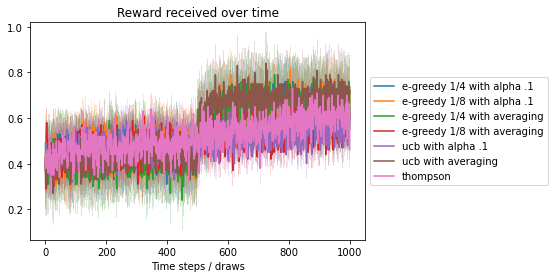

In [48]:
a = []
for alpha in [.1, 1]:
    
    for epsilons in [1/4,1/8]:
        a_greedy, b_greedy, c_greedy, d_greedy = run(runs, time_steps, epsilon=epsilons, alpha=alpha,non_stationay=True)
        a.append(a_greedy)
        
        
    a_ucb, b_ucb, c_ucb, d_ucb = run(runs, time_steps,alpha=alpha, bandit_t='ucb',non_stationay=True)
    a.append(a_ucb)
    
    if alpha ==1:
        a_Thompson, b_Thompson, c_Thompson, d_Thompson = run(runs, time_steps,alpha=alpha, bandit_t='thompson',non_stationay=True)
        a.append(a_Thompson)
    
labels = ['e-greedy 1/4 with alpha .1','e-greedy 1/8 with alpha .1','e-greedy 1/4 with averaging','e-greedy 1/8 with averaging','ucb with alpha .1','ucb with averaging','thompson']

counter = 0
for value in a:
    line = value
    plt.plot(X, line,label=labels[counter])
    counter +=1
    arr_std = np.std(line)
    lower_bound = line - arr_std
    upper_bound = line + arr_std
    plt.fill_between(X, lower_bound, upper_bound, alpha=0.2,linewidth=4,
                     linestyle='dashdot', antialiased=False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Reward received over time")
    plt.xlabel("Time steps / draws")
plt.show()
    
    #plot reward graph for this alpha
    

### Comments
On a non-stationary case the thompson algorithm was one of the worst, indicating that it shines mainly on stationary problems, while others like the ucb with alpha 1 or the e-greedy 1/8 with alpha .1 can adapt to the changes.